In [2]:
import sys
import torch
import utils

# settings 
batch_size = 3
device = 'cuda' if torch.cuda.is_available else 'cpu'



import albumentations as A
from albumentations.pytorch import ToTensorV2
bcad_img = './images'
bcad_ann = './annotations/v1v2_ann.json'

trtf = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(),
                ToTensorV2(),
                ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])
                )
                


valtf = A.Compose([
                  A.Normalize(),
                  ToTensorV2()
                  ])

tetf = A.Compose([
                  A.Normalize(),
                  ToTensorV2()
                  ])

from dataset import BurnedCAD_is

dataset = BurnedCAD_is(root=bcad_img,annFile=bcad_ann, mode='train', transform=trtf)

import torch
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

trdl = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

# tedl = torch.utils.data.DataLoader(
    # dataset_test, batch_size=1, shuffle=False, num_workers=4,
    # collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [2]:
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

In [3]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from engine import train_one_epoch, evaluate
device='cuda:1'

evaluators = []
model.to(device)
num_epochs = 200
for epoch in range(num_epochs):
    
    print('train =============')
    train_one_epoch(model, optimizer, trdl, device, epoch, print_freq=10)

    lr_scheduler.step()
    # evaluate on the test dataset
    # device = 'cuda:1'
    # model.to(device)
    print('evaluate =============')
    evaluators.append( evaluate(model, trdl, device=device) )

## model save&load 

In [ ]:
model_path = './models/mrcnn_400.pth'
torch.save({'state_dict':model.state_dict(),
                'evaluators':evaluators
           },model_path)

In [ ]:
# evaluators visualization

## evaluators 

### MRCNN 0~200 epch 

In [1]:
import os
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

import torch
model_path = './models/mrcnn_200.pth'
model_name = os.path.splitext(os.path.basename(model_path))[0]
model_dict = torch.load(model_path)

model.load_state_dict(model_dict['state_dict'])

evaluators = model_dict['evaluators']

metrics = {}
metric_types = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
for metric in metric_types:
    metrics[metric] = []


for evtor in evaluators:
    for iou_type, coco_eval in evtor.coco_eval.items():
        #coco_eval.summarize()
        #  iou_type : 'bbox' ,'segm'
        if iou_type == 'bbox':
            aps = coco_eval.stats[:3]
            metrics['ap'].append(aps[0])
            metrics['ap50'].append(aps[1])
            metrics['ap75'].append(aps[2])

        else : # 'segm'
            aps = coco_eval.stats[:3]
            metrics['Maskap'].append(aps[0])
            metrics['Maskap50'].append(aps[1])
            metrics['Maskap75'].append(aps[2])


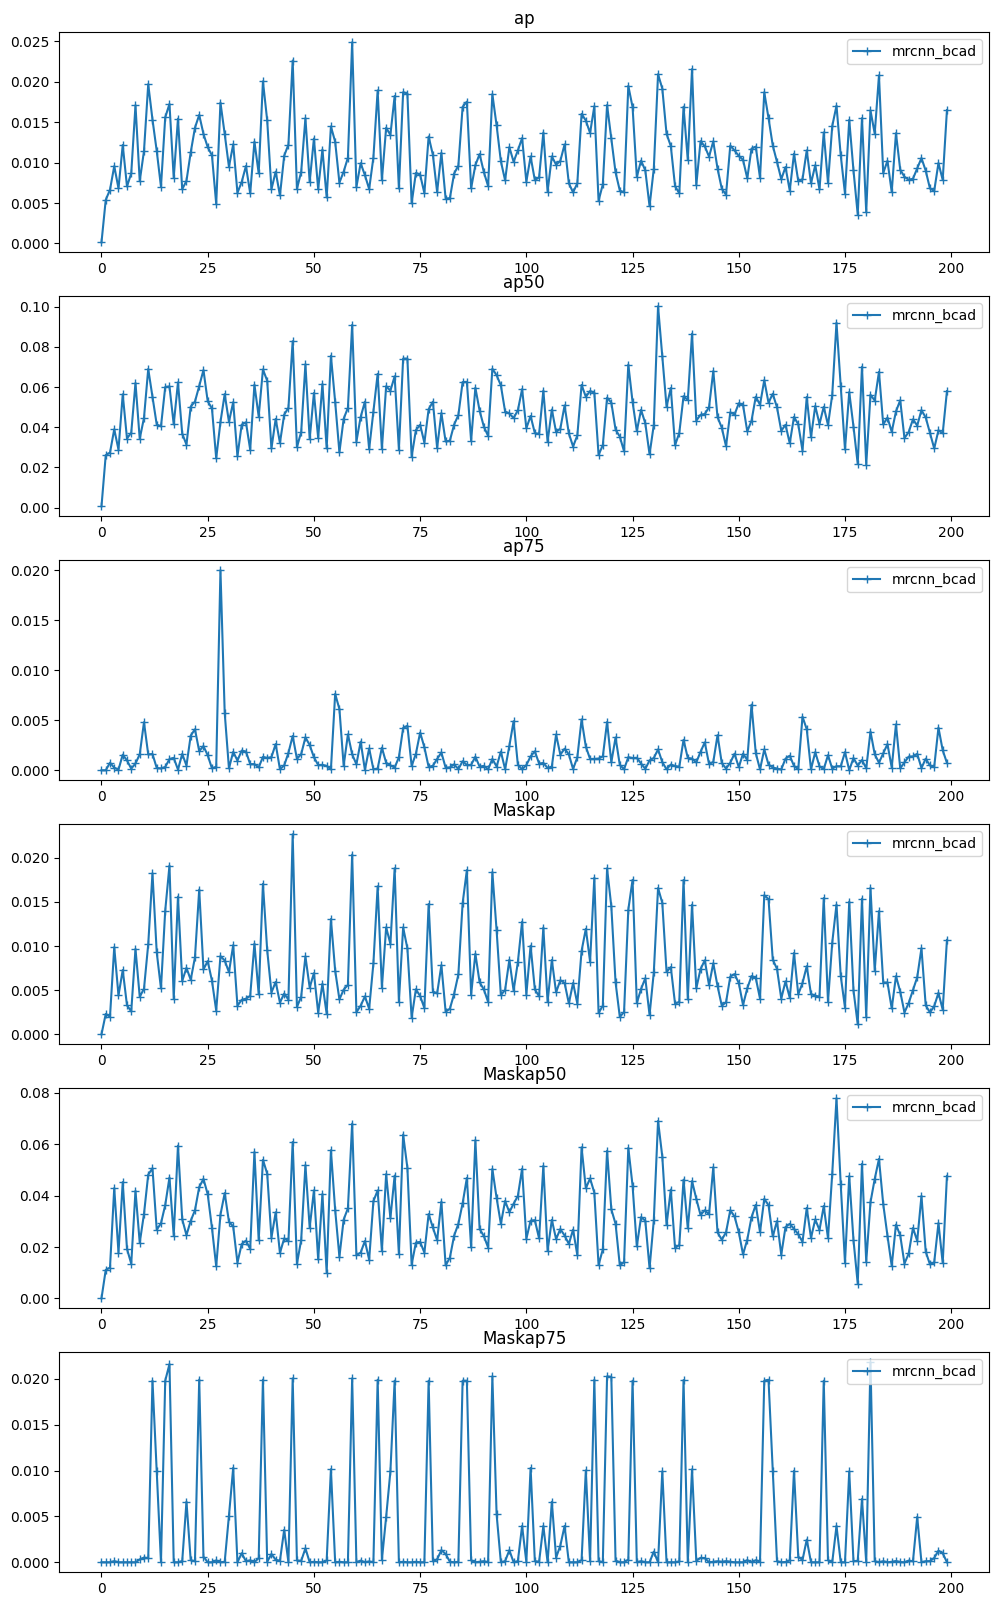

In [9]:
from matplotlib import pyplot as plt
f, axs = plt.subplots(len(metric_types), 1, figsize=(12, 20),sharex=False) # w,h

for i,met_name in enumerate(metrics):
    axs[i].set_title(met_name)
    axs[i].plot( metrics[met_name][:],'-+',label='mrcnn_bcad')
    axs[i].legend()

plt.savefig(f'assets/{model_name}.png')

In [10]:
import pandas as pd
num_epoch = -1
aps = []

bbox = evaluators[num_epoch].coco_eval['bbox'].stats[:3]
segm = evaluators[num_epoch].coco_eval['segm'].stats[:3]
row = bbox.tolist()+segm.tolist()
aps.append(row)

import dataframe_image as dfi
df = pd.DataFrame(aps,index=[model_name],columns=metric_types)
dfi.export(df,f'./assets/{model_name}_table.png')

[0227/122342.812049:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0227/122355.424933:WARNING:sandbox_linux.cc(385)] InitializeSandbox() called with multiple threads in process gpu-process.
[0227/122355.500911:INFO:headless_shell.cc(223)] 18336 bytes written to file /tmp/tmp0mwn0762/temp.png


### MRCNN epch 0~400 

In [1]:
import os
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

import torch
model_path = './models/mrcnn_400.pth'
model_name = os.path.splitext(os.path.basename(model_path))[0]
model_dict = torch.load(model_path)

model.load_state_dict(model_dict['state_dict'])

evaluators = model_dict['evaluators']

metrics = {}
metric_types = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
for metric in metric_types:
    metrics[metric] = []


for evtor in evaluators:
    for iou_type, coco_eval in evtor.coco_eval.items():
        #coco_eval.summarize()
        #  iou_type : 'bbox' ,'segm'
        if iou_type == 'bbox':
            aps = coco_eval.stats[:3]
            metrics['ap'].append(aps[0])
            metrics['ap50'].append(aps[1])
            metrics['ap75'].append(aps[2])

        else : # 'segm'
            aps = coco_eval.stats[:3]
            metrics['Maskap'].append(aps[0])
            metrics['Maskap50'].append(aps[1])
            metrics['Maskap75'].append(aps[2])


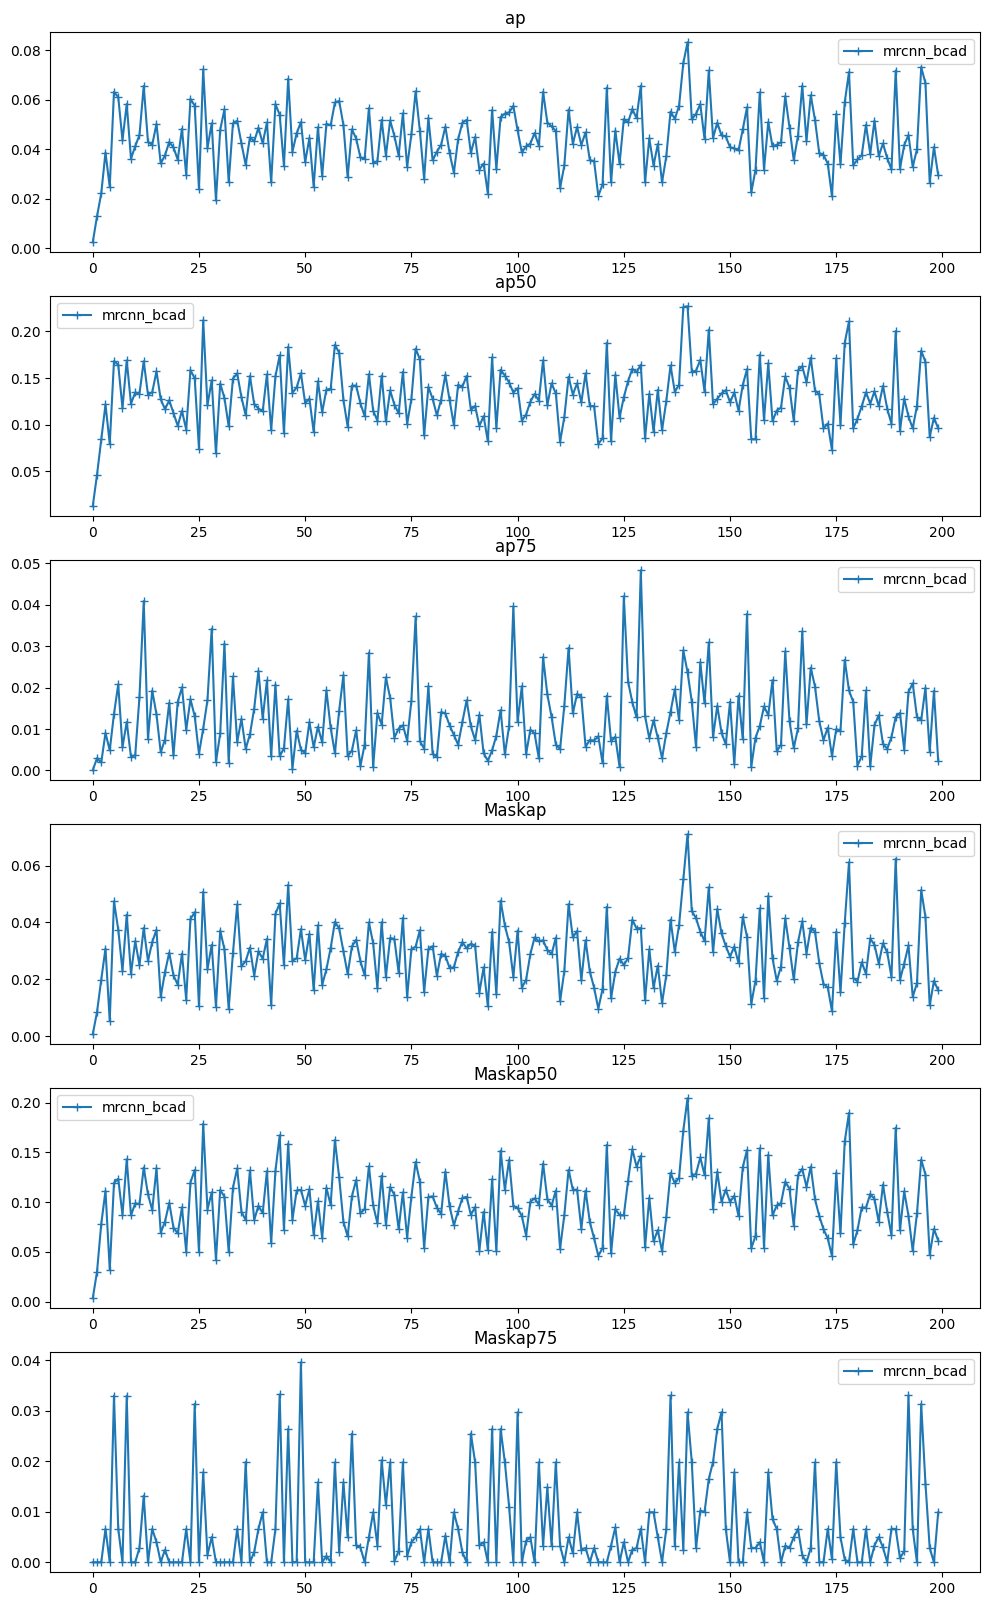

In [4]:
from matplotlib import pyplot as plt
f, axs = plt.subplots(len(metric_types), 1, figsize=(12, 20),sharex=False) # w,h

for i,met_name in enumerate(metrics):
    axs[i].set_title(met_name)
    axs[i].plot( metrics[met_name][:],'-+',label='mrcnn_bcad')
    axs[i].legend()

plt.savefig('mrcnn_400.png')

In [4]:
import pandas as pd
num_epoch = -1
aps = []

bbox = evaluators[num_epoch].coco_eval['bbox'].stats[:3]
segm = evaluators[num_epoch].coco_eval['segm'].stats[:3]
row = bbox.tolist()+segm.tolist()
aps.append(row)

import dataframe_image as dfi
df = pd.DataFrame(aps,index=[model_name],columns=metric_types)
dfi.export(df,f'./assets/{model_name}_table.png')

[0227/122643.219971:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0227/122655.941797:WARNING:sandbox_linux.cc(385)] InitializeSandbox() called with multiple threads in process gpu-process.
[0227/122655.998142:INFO:headless_shell.cc(223)] 19340 bytes written to file /tmp/tmpuxgcmde2/temp.png


### MRCNN 400~800 

In [1]:
import os
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

import torch
model_path = './models/mrcnn_800.pth'
model_name = os.path.splitext(os.path.basename(model_path))[0]
model_dict = torch.load(model_path)

model.load_state_dict(model_dict['state_dict'])

evaluators = model_dict['evaluators']

metrics = {}
metric_types = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
for metric in metric_types:
    metrics[metric] = []


for evtor in evaluators:
    for iou_type, coco_eval in evtor.coco_eval.items():
        #coco_eval.summarize()
        #  iou_type : 'bbox' ,'segm'
        if iou_type == 'bbox':
            aps = coco_eval.stats[:3]
            metrics['ap'].append(aps[0])
            metrics['ap50'].append(aps[1])
            metrics['ap75'].append(aps[2])

        else : # 'segm'
            aps = coco_eval.stats[:3]
            metrics['Maskap'].append(aps[0])
            metrics['Maskap50'].append(aps[1])
            metrics['Maskap75'].append(aps[2])


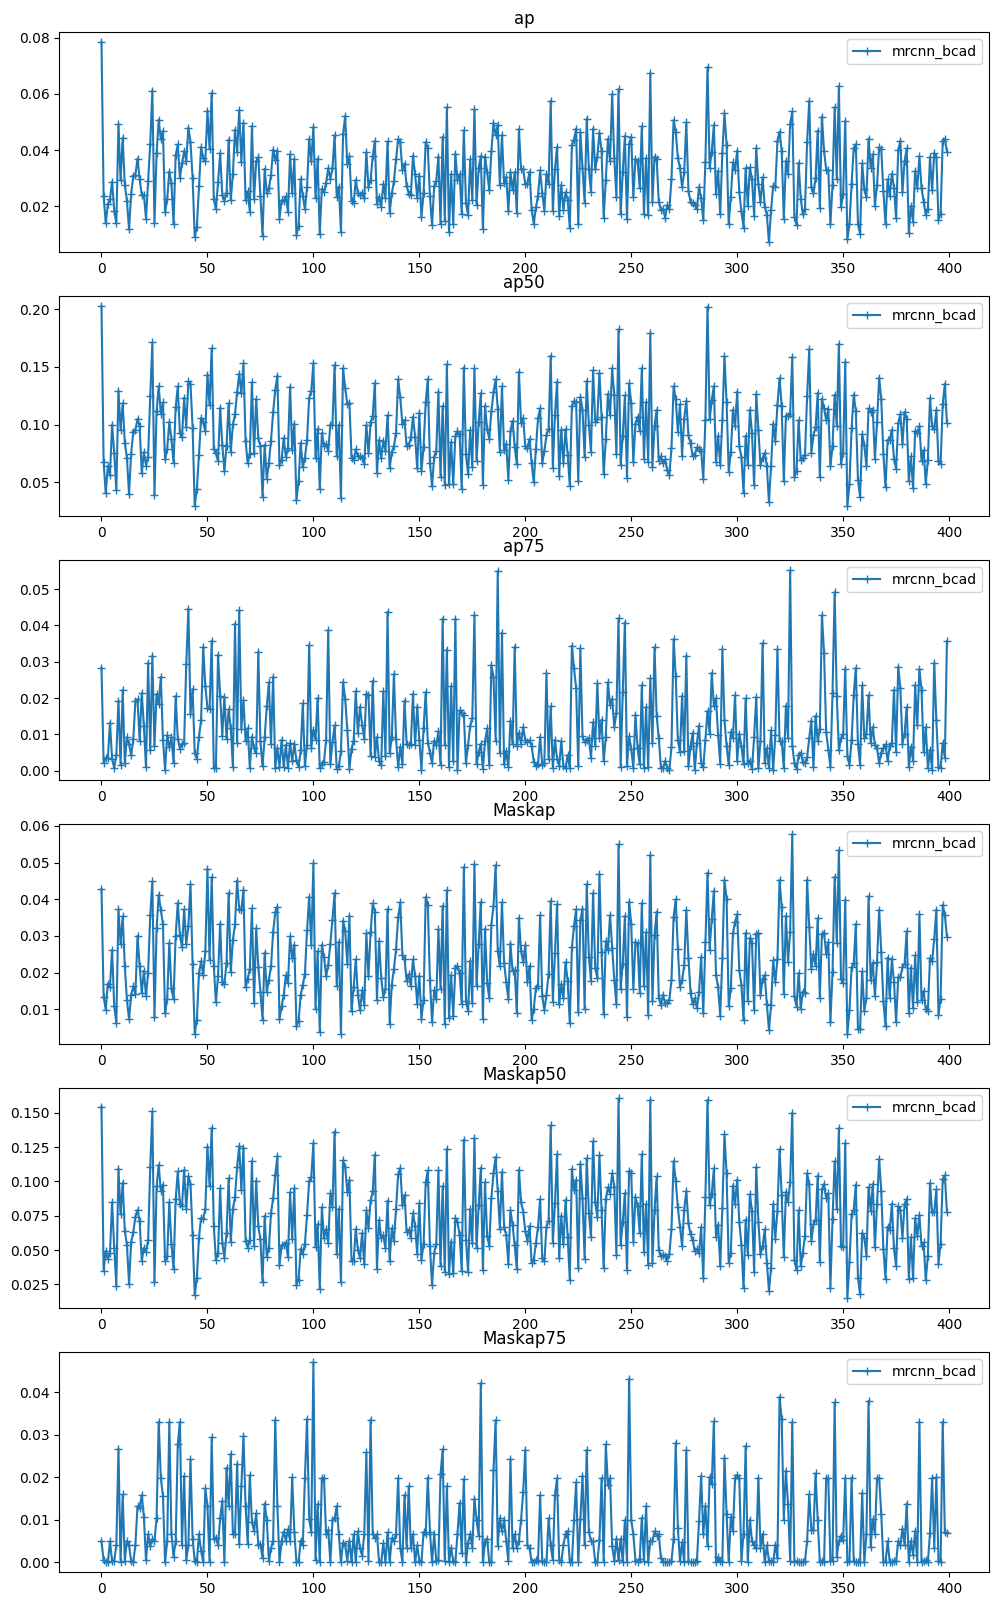

In [3]:
from matplotlib import pyplot as plt
f, axs = plt.subplots(len(metric_types), 1, figsize=(12, 20),sharex=False) # w,h

for i,met_name in enumerate(metrics):
    axs[i].set_title(met_name)
    axs[i].plot( metrics[met_name][:],'-+',label='mrcnn_bcad')
    axs[i].legend()

plt.savefig('./assets/mrcnn_800.png')

In [6]:
import pandas as pd
num_epoch = -1
aps = []

bbox = evaluators[num_epoch].coco_eval['bbox'].stats[:3]
segm = evaluators[num_epoch].coco_eval['segm'].stats[:3]
row = bbox.tolist()+segm.tolist()
aps.append(row)

import dataframe_image as dfi
df = pd.DataFrame(aps,index=[model_name],columns=metric_types)
dfi.export(df,f'./assets/{model_name}_table.png')

[0227/122718.618613:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0227/122731.193099:WARNING:sandbox_linux.cc(385)] InitializeSandbox() called with multiple threads in process gpu-process.
[0227/122731.265203:INFO:headless_shell.cc(223)] 19340 bytes written to file /tmp/tmpt4lawymc/temp.png


### ? next 

In [1]:
import os
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

import torch
model_path = './models/mrcnn_cp_400.pth'
model_name = os.path.splitext(os.path.basename(model_path))[0]
model_dict = torch.load(model_path)

model.load_state_dict(model_dict['state_dict'])

evaluators = model_dict['evaluators']

metrics = {}
metric_types = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
for metric in metric_types:
    metrics[metric] = []


for evtor in evaluators:
    for iou_type, coco_eval in evtor.coco_eval.items():
        #coco_eval.summarize()
        #  iou_type : 'bbox' ,'segm'
        if iou_type == 'bbox':
            aps = coco_eval.stats[:3]
            metrics['ap'].append(aps[0])
            metrics['ap50'].append(aps[1])
            metrics['ap75'].append(aps[2])

        else : # 'segm'
            aps = coco_eval.stats[:3]
            metrics['Maskap'].append(aps[0])
            metrics['Maskap50'].append(aps[1])
            metrics['Maskap75'].append(aps[2])


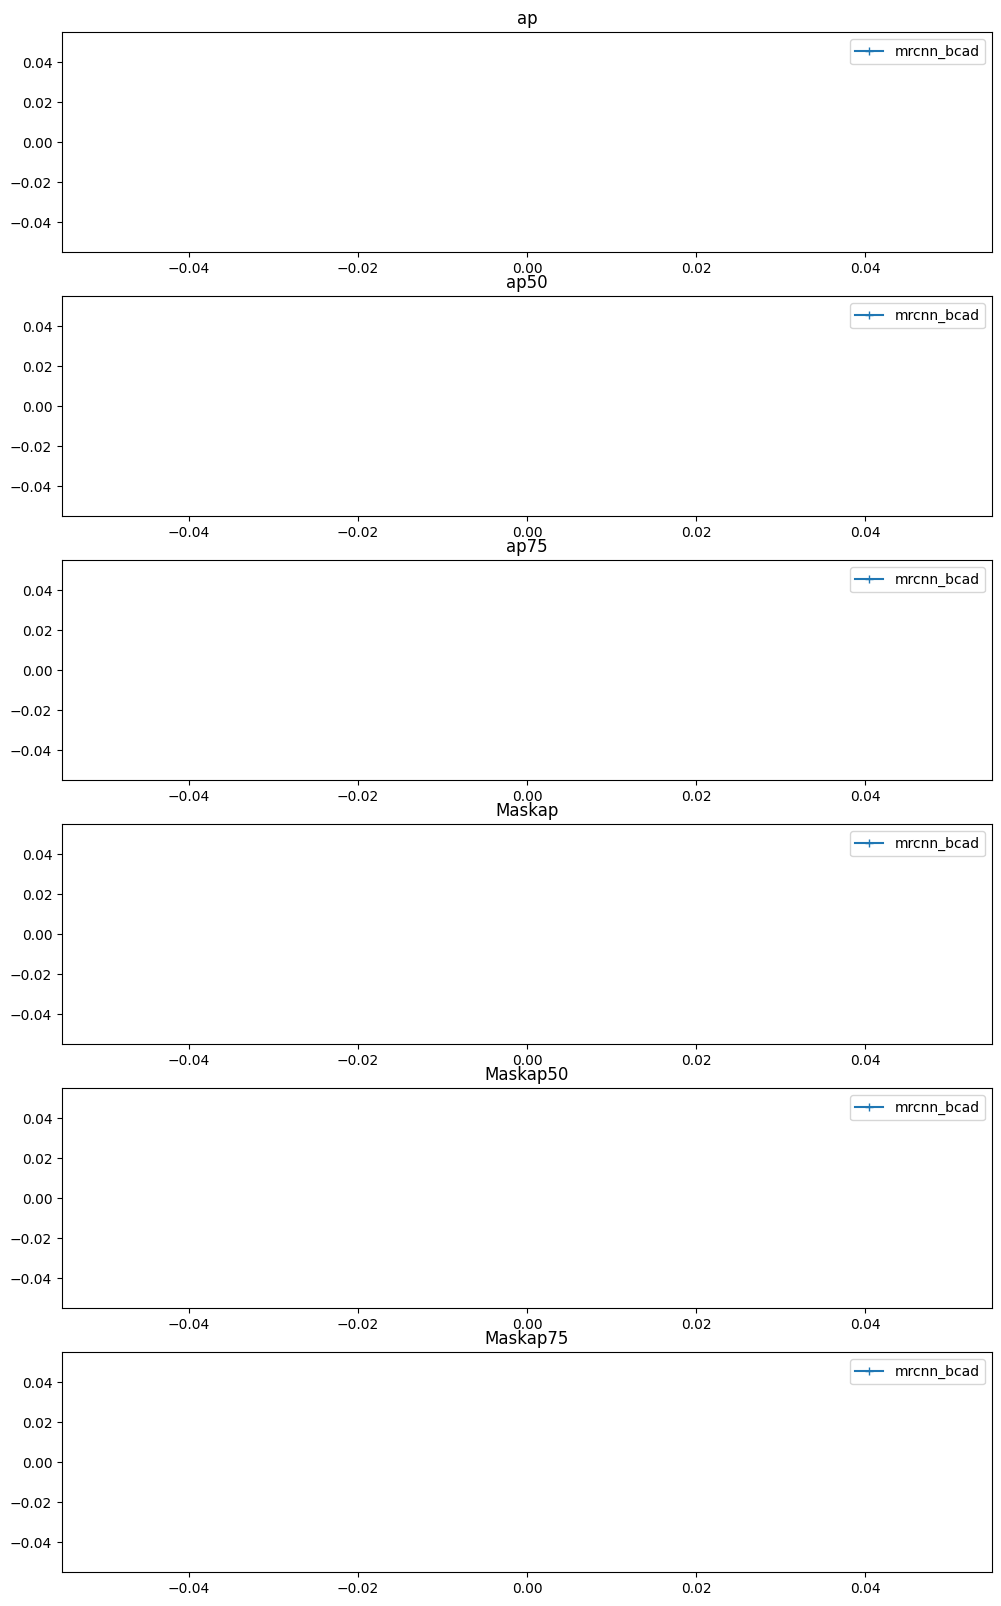

In [2]:
from matplotlib import pyplot as plt
f, axs = plt.subplots(len(metric_types), 1, figsize=(12, 20),sharex=False) # w,h

for i,met_name in enumerate(metrics):
    axs[i].set_title(met_name)
    axs[i].plot( metrics[met_name][:],'-+',label='mrcnn_bcad')
    axs[i].legend()

plt.savefig(f'./assets/{model_name}.png')

In [6]:
import pandas as pd
num_epoch = -1
aps = []

bbox = evaluators[num_epoch].coco_eval['bbox'].stats[:3]
segm = evaluators[num_epoch].coco_eval['segm'].stats[:3]
row = bbox.tolist()+segm.tolist()
aps.append(row)

import dataframe_image as dfi
df = pd.DataFrame(aps,index=[model_name],columns=metric_types)
dfi.export(df,f'./assets/{model_name}_table.png')

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
a,0.045858,0.13329,0.017745,0.024953,0.097956,0.00288


## vis. 

In [18]:
import argparse
import importlib
import torch
import utils

import os
import sys

import torchvision
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def draw_ann(img,scores,boxes,masks=None,nms=True,iou_threshold=0.5,conf_threshold=0.4 ,mask_threshold=0.5): # pil , tensor,tensor,float

    dis_rgbs = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128),
        (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
    msk  = masks is not None
    size = img.size[::-1]

    # nms
    if nms :
        idx = torchvision.ops.nms(boxes,scores,iou_threshold=0.3)
        boxes  = boxes[idx]
        scores = scores[idx]
        if msk :
            masks = masks[idx]
    if conf_threshold :
        condition = scores>conf_threshold
        boxes  = boxes[condition]
        scores = scores[condition]   
        if msk :
            masks = masks[condition]
    if msk :
        if  'cuda' in masks.device.type:
            masks = masks.clone().detach().cpu()
        summask = np.zeros(size+(3,),dtype='uint8')
        for i,mask in enumerate(masks): 
            condi      = np.array(mask>0.5)
            condi_3    = np.concatenate([condi.reshape(size+(1,) )]*3,axis=2)
            colorMask  = np.array(Image.new('RGB',(size[1],size[0]),dis_rgbs[i]) )
            colorMask  = colorMask * condi_3 

            # multiply 1/2 if overlapped        
#             overlapped = (colorMask.sum(0) * summask.sum(0)).astype('bool')
#             overlapped = np.stack([overlapped,overlapped,overlapped]).reshape( num_condi.shape+(3,))
#             overMask   = colorMask*overlapped//2 + summask*overlapped//2
#             summask    = summask*(~overlapped) + colorMask*(~overlapped)
#             summask    = summask + overMask
            summask    = summask + (colorMask)
        # summask brightness
#         overlapped = 
#         imgnp , summask = np.array(img)[overlapped]//2 + summask[overlapped]//2
        imgnp           = np.array(img)
        img = Image.fromarray(imgnp+summask ) 
    
    annimg = img.copy()
    draw = ImageDraw.Draw(annimg)
    font = ImageFont.load_default()
    
    for i,box in enumerate(boxes):
        # draw.rectangle(xy=[0,0,150,150],outline=dis_rgb[2] )#, outline=label_color_map[det_labels[i]])
        box_xy = box.tolist()
        draw.rectangle(xy=box_xy,outline=dis_rgbs[i%len(dis_rgbs)] )#, outline=label_color_map[det_labels[i]])
        title = str(round(scores[i].item(),4))
        draw.text(xy=[box_xy[0]+len(title),box_xy[1]-1],text=title,fill='white',font=font)
    del draw
        
    
    return annimg

In [ ]:
# file > pil > tensor
from PIL import Image
from torchvision.transforms import functional as vfc 
img     = Image.open(args.input).convert('RGB')

imgt    = vfc.to_tensor(img).to(device = device)

In [43]:
# tensor > 
idx = 4
x,y  = dataset_test[idx]

import torchvision.transforms as T

img = T.ToPILImage()(imgt).convert('RGB')
imgt = x.to(device = device)

model.eval()
pre     = model([imgt])

# draw prediction annotation (Mask ,Bbox ,score)
annimg = draw_ann(img,pre[0]['scores'].cpu(),pre[0]['boxes'].cpu(),pre[0]['masks'].cpu(),nms=True,conf_threshold=0.4)

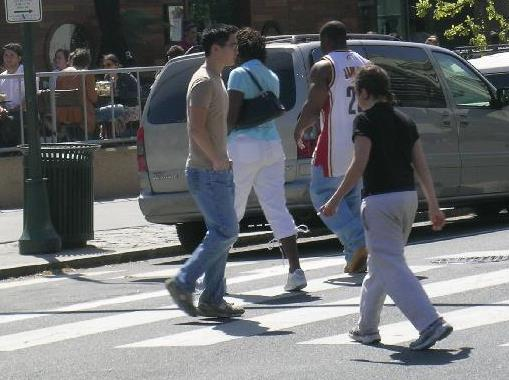

In [45]:
img

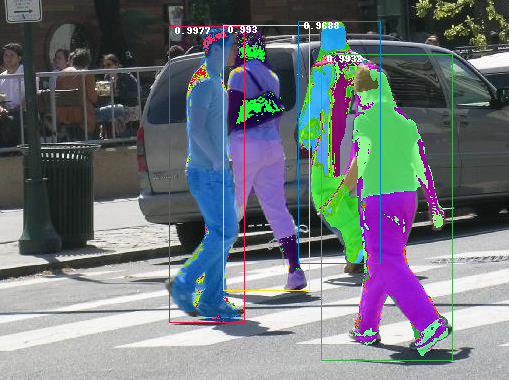

In [44]:
annimg

In [27]:
annimg.save('result.png')

## evaluator vis.

In [8]:
evaluators